In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly

Constructing a function $f(x)$

In [4]:
# f = lambda x : x**2
# print (f(4))

Construct the dual $f^*$ of $f$.

*Theory:* 

\begin{align}
    x &\to \mathbb R \\
    x'' &\to \mathbb R \\
    \hat x (f) &= f(x)
\end{align}

A number expressed as a function

In [5]:
# x = lambda f: f(4.)
# g = lambda x: x**2
# print (x(g))

Construct a set of this special points, that given a function return a value, we call this set $\hat N$ (the **set of nodal functions**, that are a basis for the dual space of $\hat{\mathcal{P}}^k([0,1])$). 

In [6]:
# defined on some points on the domain [0,1]
def construct_dual_basis_1():
    N = []
    N.append(lambda f: f(0.))
    #N.append(lambda f: f(1./3))
    #N.append(lambda f: f(.5))
    #N.append(lambda f: f(2./3))
    N.append(lambda f: f(1.))
    return N

def construct_dual_basis_2():
    N = []
    N.append(lambda f: f(0.))
    #N.append(lambda f: f(1./3))
    N.append(lambda f: f(.5))
    #N.append(lambda f: f(2./3))
    N.append(lambda f: f(1.))
    return N

def construct_dual_basis_3():
    N = []
    N.append(lambda f: f(0.))
    N.append(lambda f: f(1./3))
#     N.append(lambda f: f(.5))
    N.append(lambda f: f(2./3))
    N.append(lambda f: f(1.))
    return N

In [8]:
# p = lambda p : p(0)
# f = lambda x : x

# Nk = construct_dual_basis_2()

# print (Nk)
# print (Nk[0](f))
# print (Nk[1](f))

$\mathcal{P}^k([0,1]) = \textrm{span}\{e_i\}_{i=0}^k =: \textrm{span} E$
As we are free to choose our polinomials, we pick them in their simplest possible form, monomials:
$$
e_i = \mathrm{pow}(x,i)
$$

In [14]:
def construct_poly(deg):
    E = []
    for i in range(deg+1):
        c = np.zeros((i+1,))
        c[-1] = 1
        E.append(poly.Polynomial(c))
    return E

Sample finite elements: https://femtable.org/

Simple finite element triplet:

In [15]:
deg = 3

Tk = np.array([0,1])          # domain of element
Nk = construct_dual_basis_3()   # dual basis / generator of coefficients 
                              # degrees of freedom
Pk = construct_poly(deg)      # polynomial basis
print (Tk)
print (Nk)
print (Pk)

[0 1]
[<function <lambda> at 0x10c0315f0>, <function <lambda> at 0x10c031668>, <function <lambda> at 0x10c0316e0>, <function <lambda> at 0x10c031758>]
[Polynomial([ 1.], [-1,  1], [-1,  1]), Polynomial([ 0.,  1.], [-1,  1], [-1,  1]), Polynomial([ 0.,  0.,  1.], [-1,  1], [-1,  1]), Polynomial([ 0.,  0.,  0.,  1.], [-1,  1], [-1,  1])]


We construct basis functions $v_i$ asking them to be those particular polynomials orthogonal to the degrees of freedom $v^j$. In a compact way this means:

$$
v^j\, v_i = \delta^j_i
$$

$v^j$ are a special kind of points that given a function the do return a value. We can write this value for the $k$-th polynomial:

$v^j(e_k)$, and introduce the matrix $C_k^j$. This matrix clarifies the way canonical basis functions are related with the degrees of freedom:


$$
v^j\, v_i = \delta^j_i, \quad v^j(e_k)\, v^k_i = \delta^j_i, \quad C^j_k\, v^k_i = \delta^j_i
$$

Reading the last formula we get an easy way to construct the basis functions:

$$
v^k_i = (C^j_k)^{-1}\delta^j_i
$$

In practice these $v^k_i$ are the cofficents for the polynomials that are going to become the basis for our space.  

In [16]:
def construct_cij(N,P):
    C = np.zeros((0,len(P)))
    for dof in N:
        row = np.array([])
        for p in P:
            row = np.hstack((row,dof(p)))
        C = np.vstack((C,row))
    return C

construct_cij(Nk,Pk)

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.33333333,  0.11111111,  0.03703704],
       [ 1.        ,  0.66666667,  0.44444444,  0.2962963 ],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

In [17]:
def construct_canonical_basis(C):
    V = []
    for k in range(C.shape[0]):
        delta_ij = np.zeros(C.shape[0])
        delta_ij[k] = 1
        vk = np.linalg.solve(C,delta_ij)
        V.append(poly.Polynomial(vk))
    return V

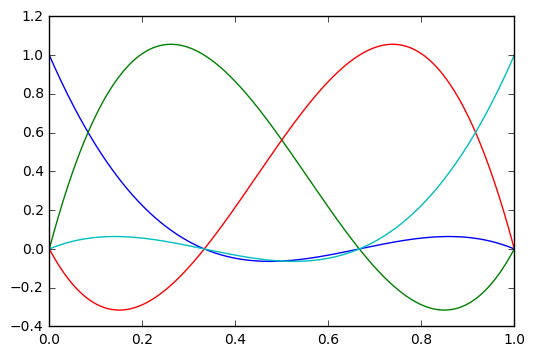

In [18]:
C = construct_cij(Nk,Pk)
V = construct_canonical_basis(C)

s = np.linspace(0,1,1025)
for v in V:
    plt.plot(s, v(s))
plt.show()


In [19]:
from numpy.polynomial.legendre import leggauss

def apply_matrx_bc(A):
    ck = A[0,0]
    A[0] = 0
    A[0,0] = ck
    
    ck = A[-1,-1]
    A[-1] = 0
    A[-1,-1] = ck
    
def apply_rhs_bc(rhs):
    rhs[0] = 0
    rhs[-1] = 0

def assemble_system(x,V,myf):
    
    h = 1./(len(x)-1)
    print(h)
    degree = 2*len(V)-1
    q,w = leggauss(degree)  # Gauss between -1 and 1 
                            # returns quadrature weights and quadrature points
    q = (q+1)/2 # Go back to 0,1 
    w = w/2
    
    Vq = np.zeros((len(V), len(q)))
    Vpq = np.zeros((len(V), len(q)))

    for i in range(len(V)):
        Vq[i] = V[i](q)
        Vpq[i] = V[i].deriv()(q)

    n_dofs = (len(x)-1)*(len(V)-1)+1
    
    # Prepare the global variables
    A = np.zeros((n_dofs, n_dofs))      # stiffness matrix / gradu-gradv matrix
    M = np.zeros((n_dofs, n_dofs))      # mass matrix
    rhs = np.zeros((n_dofs,))

    # Construct the local matrix only once:
    local_A = np.einsum('jq, iq, q -> ij', Vpq/h, Vpq/h, w*h)
    local_M = np.einsum('jq, iq, q -> ij', Vq, Vq, w*h)

    for i in range(len(x)-1):
        start = i*(len(V)-1)
        end = start+len(V)

        index = range(start, end)
        A[np.ix_(index, index)] += local_A
        M[np.ix_(index, index)] += local_M

        # The transformation of the quadrature points
        xq = x[i]+h*q
        local_rhs = np.einsum('iq, q, q -> i', Vq, w*h, myf(xq))

        rhs[index] += local_rhs

    # Fix the boundary conditions
    apply_matrx_bc(A)
    apply_matrx_bc(M)
    apply_rhs_bc(rhs)
    #ck = A[0,0]
    #A[0] = 0
    #A[0,0] = ck
    #rhs[0] = 0

    
    #ck = A[-1,-1]
    #A[-1] = 0
    #A[-1,-1] = ck
    #rhs[-1] = 0        

    return A,M,rhs

In [20]:
def evaluate_l2_error(x,V,u,exact_sol):
    '''Evaluate the L^2 norm of the error'''
    h = 1./(len(x)-1)

    degree = 2*len(V)-1
    q,w = leggauss(degree)  # Gauss between -1 and 1 
                            # returns quadrature weights and quadrature points
    q = (q+1)/2 # Go back to 0,1 
    w = w/2
    
    Vq = np.zeros((len(V), len(q)))
    Vpq = np.zeros((len(V), len(q)))

    for i in range(len(V)):
        Vq[i] = V[i](q)
        Vpq[i] = V[i].deriv()(q)

    error = 0
    for i in range(len(x)-1):
        start = i*(len(V)-1)
        end = start+len(V)

        index = range(start, end)
        xq = x[i] + q*h
    
        fem_sol = np.einsum( 'j, jq -> q', u[index], Vq)
        an_sol = exact_sol(xq)
        
        error += np.sum( (fem_sol-an_sol)**2 * w )

    return np.sqrt(error)
# def evaluate_h1_error(x,V,u,exact_sol_der):

In [21]:
# construct the exact solution
import sympy as sym
t = sym.var('t')
sol = t**2*(1-t)
force_a = -1*sym.diff(sol,t,2)

0.25
0.111111111111
0.0625
0.04
0.0277777777778
0.0204081632653
0.015625
0.0123456790123


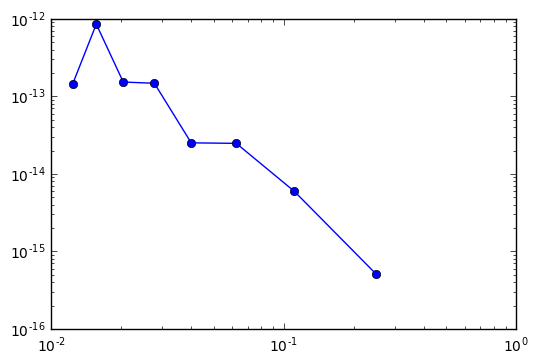

In [22]:
dx = []
l2_error = []

for n in np.arange(2,10):
    n = n**2+1
    x = np.linspace(0,1,n)
    
    dx.append(1.0/(n-1.0))
    
    force = sym.lambdify(t,force_a,"numpy")
    sol_n = sym.lambdify(t,sol,"numpy")
    A,M,rhs = assemble_system(x,V,force)

    ufem = np.linalg.solve(A,rhs)

    l2_error.append(evaluate_l2_error(x,V,ufem,sol_n))

_=plt.loglog(dx,l2_error,'-o')
# _=plt.loglog(dx,np.array(dx)**2,'--',label='$h^2$')
# _=plt.loglog(dx,np.array(dx)**(1.5),'--',label='$h^{3/2}$')
# _=plt.legend(loc=0)

In [23]:
1.63733964

1.63733964

In [24]:
def interpolation_matrix(s, x, V):
    """
    Given the evaluation points s in the mesh x, construct the interpolation matrix 
    according to the local basis V.
    """
    n_dofs = (len(x)-1)*(len(V)-1)+1

    M = np.zeros((n_dofs, len(s)))
    for i in range(len(x)-1):
        index = s>=x[i]
        index *= s<=x[i+1]
        
        # Transform the points to [0,1]
        xi = (s[index]-x[i])/(x[i+1]-x[i])
        
        for j in range(len(V)):
            k = i*(len(v)-1)+j
            M[k,index] = V[j](xi)
    return M

('Error at the s points:', 2.298161660974074e-14)
('Error at the x points:', 2.2815083156046967e-14)


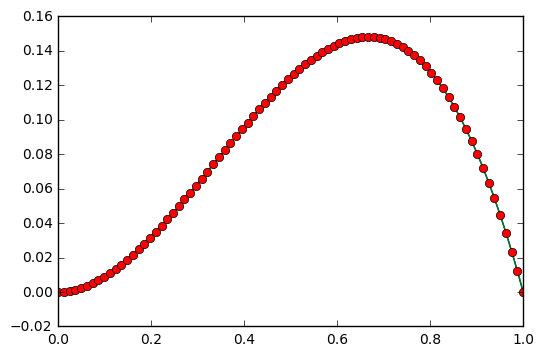

In [25]:
sol_n = sym.lambdify(t,sol,"numpy")
s = np.linspace(0,1,1025)
us = sol_n(s)
# x = np.linspace(0,1,9)
ux = sol_n(x)
# us = np.sin(2*np.pi*s)
# ux = np.sin(2*np.pi*x)

# Use this to plot high resolution versions
M = interpolation_matrix(s,x,V)

# Use this to compute errors at the mesh points
Mx = interpolation_matrix(x,x,V)

plt.plot(s, M.T.dot(ufem))
plt.plot(s, us)
plt.plot(x, ux,'ro')

print("Error at the s points:", (M.T.dot(ufem)-us).max())
print("Error at the x points:", (Mx.T.dot(ufem)-ux).max())